# Load Kaggle API key

In [1]:
from google.colab import userdata

# prompt: load username and key from  from google.colab import userdata
# userdata.get('secretName')

username = userdata.get('username')
key = userdata.get('key')


In [2]:
# prompt: create kaggle.json  in /root/.config/kaggle.  using loaded username and key

import json
import os

# Ensure the directory exists
if not os.path.exists('/root/.config/kaggle'):
    os.makedirs('/root/.config/kaggle')

# Define the path for the kaggle.json file
kaggle_json_path = '/root/.config/kaggle/kaggle.json'

# Create the dictionary structure for the kaggle.json file
kaggle_config = {"username": username, "key": key}

# Write the dictionary to the kaggle.json file as JSON
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_config, f)

# Set appropriate permissions for the kaggle.json file
os.chmod(kaggle_json_path, 0o600)

print(f"kaggle.json created at {kaggle_json_path}")

kaggle.json created at /root/.config/kaggle/kaggle.json


# Download dataset

In [3]:
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 564MB/s]


# Text preprocessing

## Extractor

In [4]:
import zipfile
import os

zip_path = 'tweet-sentiment-extraction.zip'
extract_dir = 'tweet-sentiment-extraction'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted '{zip_path}' to '{extract_dir}/'")

Extracted 'tweet-sentiment-extraction.zip' to 'tweet-sentiment-extraction/'


## Preprocessor

In [5]:
!pip install emoji contractions nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.7 MB/s eta 0:00:00


In [6]:
import pandas as pd

train = pd.read_csv('tweet-sentiment-extraction/train.csv')
test = pd.read_csv('tweet-sentiment-extraction/test.csv')

import re
import emoji
import contractions
import string
import nltk

from nltk.corpus import stopwords

# Make sure these are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')



# Precompiled patterns
pattern_web     = re.compile(r"(([\w]+:)?//)?(([\d\w]|%[a-fA-F\d]{2})+(:([\d\w]|%[a-fA-f\d]{2})+)?@)?([\d\w][-\d\w]{0,253}[\d\w]\.)+[\w]{2,4}(:[\d]+)?(/([-+_~.\d\w]|%[a-fA-f\d]{2})*)*(\?(&?([-+_~.\d\w]|%[a-fA-f\d]{2})=?)*)?(#([-+_~.\d\w]|%[a-fA-f\d]{2})*)?")
pattern_email   = re.compile(r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)])")
pattern_hash    = re.compile(r'#(\w+)')
pattern_handle  = re.compile(r'@\w+')
pattern_repeat  = re.compile(r'([A-Za-z])\1{2,}')
pattern_num     = re.compile(r'[0-9]')
pattern_apos    = re.compile(r'[`’]')
# We'll strip all punctuation except our <EXC> and <QUES> tokens
# So exclude '<', '>', and letters in those tokens from the regex
punct_to_keep   = '<> '
all_punc        = set(string.punctuation) - set('<>')
pattern_punc    = re.compile(f"[{re.escape(''.join(all_punc))}]")
pattern_special = re.compile(r'[^a-zA-Z0-9\s<>]')
pattern_space   = re.compile(r'\s+')

def preprocess_single_text(tweet: str) -> str:
    # 1) Emoji → text
    tweet = emoji.demojize(str(tweet))

    # 2) URLs, emails, hashtags, handles
    tweet = pattern_web.sub(' ', tweet)
    tweet = pattern_email.sub(' ', tweet)
    tweet = pattern_hash.sub(r' \1', tweet)  # keep just the word of #tag
    tweet = pattern_handle.sub(' ', tweet)

    # 3) Normalize apostrophes + expand contractions
    tweet = pattern_apos.sub("'", tweet)
    tweet = contractions.fix(tweet)

    # 4) Map repeated sentiment punctuation
    tweet = re.sub(r'!{2,}', ' <EXC> ', tweet)
    tweet = re.sub(r'\?{2,}', ' <QUES> ', tweet)

    # 5) Character repeats, numbers, punctuation, special chars
    tweet = pattern_repeat.sub(r'\1', tweet)
    tweet = pattern_num.sub(' ', tweet)
    tweet = pattern_punc.sub(' ', tweet)
    tweet = pattern_special.sub(' ', tweet)

    # 6) Lowercase
    tweet = tweet.lower()

    # 7) Whitespace normalization
    tweet = pattern_space.sub(' ', tweet).strip()

    return tweet

def preprocess_dataset(dataset: pd.DataFrame):
    # drop textID and selected_text column if exists
    cols_to_drop = [col for col in ['textID', 'selected_text'] if col in dataset.columns]
    dataset = dataset.drop(columns=cols_to_drop)

    # Apply preprocess_single_text to each row of 'text'
    if 'text' in dataset.columns:
        dataset['text'] = dataset['text'].apply(preprocess_single_text)

    return dataset


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
print ("Before text processing...")
print(train)
print(test)

print ("After text processing...")
train = preprocess_dataset(train)
test  = preprocess_dataset(test)
print(train)
print(test)

Before text processing...
           textID                                               text  \
0      cb774db0d1                I`d have responded, if I were going   
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2      088c60f138                          my boss is bullying me...   
3      9642c003ef                     what interview! leave me alone   
4      358bd9e861   Sons of ****, why couldn`t they put them on t...   
...           ...                                                ...   
27476  4eac33d1c0   wish we could come see u on Denver  husband l...   
27477  4f4c4fc327   I`ve wondered about rake to.  The client has ...   
27478  f67aae2310   Yay good for both of you. Enjoy the break - y...   
27479  ed167662a5                         But it was worth it  ****.   
27480  6f7127d9d7     All this flirting going on - The ATG smiles...   

                                           selected_text sentiment  
0                    I`d have responded,

## Tokenization

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
import numpy as np
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

# Setup
stop_words = set(stopwords.words('english'))

# Preserve negators
for neg in ['not', 'no', 'never', 'none', 'nobody', 'nothing', "don't", "didn't", "can't", "won't"]:
    stop_words.discard(neg)

def tokenize_single_text(text):

    words = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    Words = [word for word in words if word not in stop_words]

    Words = [word for word in Words if len(word) > 3]

    indices = np.unique(Words, return_index=True)[1]
    cleaned_text = np.array(Words)[np.sort(indices)].tolist()

    return cleaned_text

def tokenize_dataset(dataset):
    dataset['text'] = dataset['text'].apply(tokenize_single_text)
    return dataset


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...


Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/README  
  inflating: /kaggle/w

In [9]:
print ("After tokenization...")
train = tokenize_dataset(train)
test  = tokenize_dataset(test)
print(train)
print(test)

After tokenization...
                                                    text sentiment
0                              [would, responded, going]   neutral
1                                          [miss, diego]  negative
2                                             [bullying]  negative
3                              [interview, leave, alone]  negative
4                      [could, release, already, bought]  negative
...                                                  ...       ...
27476  [wish, could, come, denver, husband, lost, aff...  negative
27477  [wondered, rake, client, made, clear, force, d...  negative
27478  [good, enjoy, break, probably, need, hectic, w...  positive
27479                                            [worth]  positive
27480                           [flirting, going, smile]   neutral

[27481 rows x 2 columns]
                                                   text sentiment
0                                       [last, session]   neutral
1     [shanghai,

In [10]:
from sklearn.model_selection import train_test_split

# Assuming 'text' is the feature and 'sentiment' is the target
X = train['text']
y = train['sentiment']

# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print (X_train.head())
print (y_train.head())
print (X_test.head())
print (y_test.head())

7025     [grade, yearbook, narnia, movie, release, blur...
15039    [remember, would, sleep, noon, well, guess, to...
1804         [momma, comin, night, morrow, tennis, yuppie]
25874            [picture, come, keep, saying, nice, ques]
27217    [feel, comfortable, using, awful, pretty, icky...
Name: text, dtype: object
7025      neutral
15039    negative
1804     positive
25874     neutral
27217    negative
Name: sentiment, dtype: object
24673                [sound, lonely, want, drive, snuggle]
25892                               [worried, safe, sound]
8824     [getting, ready, going, away, dessert, recepti...
15589                                  [think, disgusting]
11341             [know, want, come, excited, going, fast]
Name: text, dtype: object
24673    negative
25892    positive
8824      neutral
15589    negative
11341    positive
Name: sentiment, dtype: object


In [11]:
!pip install tensorflow

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
word_idx = tokenizer.word_index  # Corrected syntax for accessing word index
v = len(word_idx)
print("the size of vocab =", v)  # Corrected spacing
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

the size of vocab = 16111


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train,maxlen=maxlen)
X_test = pad_sequences(X_test,maxlen=maxlen)

print (X_train)
print (X_test)

[[   0    0    0 ... 6556 6557 6558]
 [   0    0    0 ...   27    3 1276]
 [   0    0    0 ... 1751 2854 6559]
 ...
 [   0    0    0 ...    0   23   66]
 [   0    0    0 ...   34   52   48]
 [   0    0    0 ...   93  122   54]]
[[    0     0     0 ...     8   284  2741]
 [    0     0     0 ...   780   574   132]
 [    0     0     0 ...  1986  1817    55]
 ...
 [    0     0     0 ...    27  1647   233]
 [    0     0     0 ...   285    48  2795]
 [    0     0     0 ...   252 12092  1462]]


In [14]:
y.value_counts()

,count
sentiment,
neutral,11118
positive,8582
negative,7781


# LSTM


In [15]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense,Input,GlobalMaxPooling1D,Dropout,Bidirectional
from tensorflow.keras.models import Model
from keras import optimizers
import numpy as np
D=100
inputt=Input(shape=(maxlen,))

In [16]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.0001  # Set your desired learning rate here
x=Embedding(v+1,D)(inputt)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(300,
                       dropout=0.0,
                       recurrent_dropout=0.0,
                       ))(x)
x = Dense(32, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputt, x)

# Define optimizer with specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [18]:
import tensorflow as tf

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded)

# Define callbacks
# ModelCheckpoint to save the best weights based on validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_weights.keras',  # Filepath to save the best weights
    monitor='val_loss',       # Metric to monitor
    save_best_only=True,      # Save only the best weights
    mode='min',               # Minimize validation loss
    verbose=1                 # Print when weights are saved
)

# EarlyStopping to stop training after 5 non-improving epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=5,               # Number of epochs with no improvement to wait
    mode='min',               # Minimize validation loss
    verbose=1,                # Print when training stops
    restore_best_weights=True # Restore weights from the best epoch
)

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train_one_hot,
    epochs=40,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[checkpoint, early_stopping]  # Add both callbacks
)

Epoch 1/40
685/687 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4155 - loss: 1.0800
Epoch 1: val_loss improved from inf to 0.91124, saving model to best_model_weights.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.4156 - loss: 1.0799 - val_accuracy: 0.5754 - val_loss: 0.9112
Epoch 2/40
685/687 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5930 - loss: 0.8770
Epoch 2: val_loss improved from 0.91124 to 0.79552, saving model to best_model_weights.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5931 - loss: 0.8768 - val_accuracy: 0.6480 - val_loss: 0.7955
Epoch 3/40
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6763 - loss: 0.7606
Epoch 3: val_loss improved from 0.79552 to 0.75683, saving model to best_model_weights.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.6763 - loss: 0.7606 - val_accuracy: 0.6780 - val_loss: 0.7568
Epoch 4/40
686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7119 - loss: 0.6977
Epoch 4: val_loss im

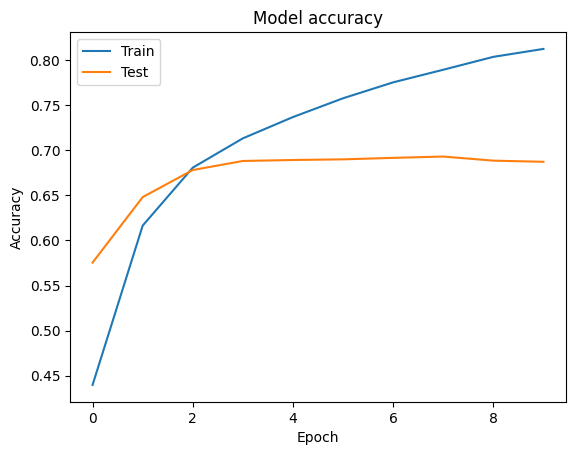

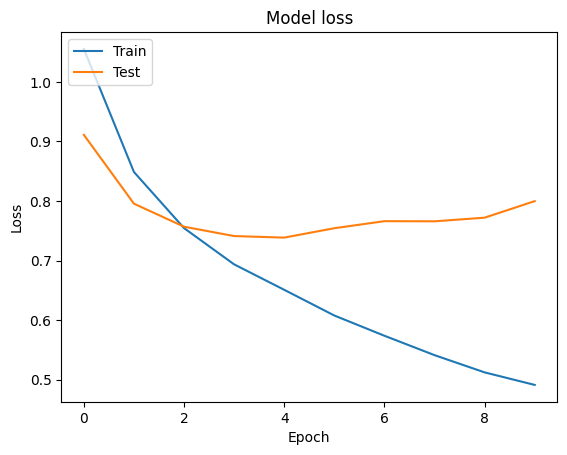

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test_one_hot)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6940 - loss: 0.7345
Test Loss: 0.7384929060935974
Test Accuracy: 0.6891031265258789


172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


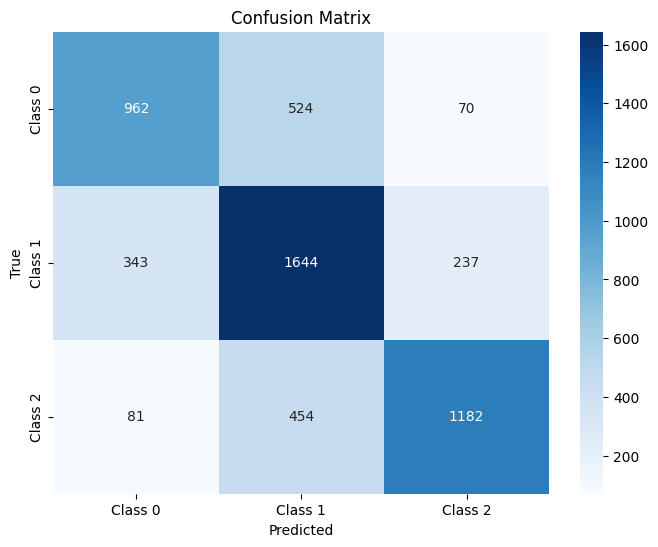

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Model evalutaion on test dataset

In [22]:
import numpy as np
# Tokenize and pad the actual test set
test_texts = test['text']
test_sequences = tokenizer.texts_to_sequences(test_texts)
X_test_actual = pad_sequences(test_sequences, maxlen=maxlen)

# Make predictions on the actual test data
test_pred_probs = model.predict(X_test_actual)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6919 - loss: 0.7337
Actual Test Loss: 0.7388327717781067
Actual Test Accuracy: 0.6796830892562866


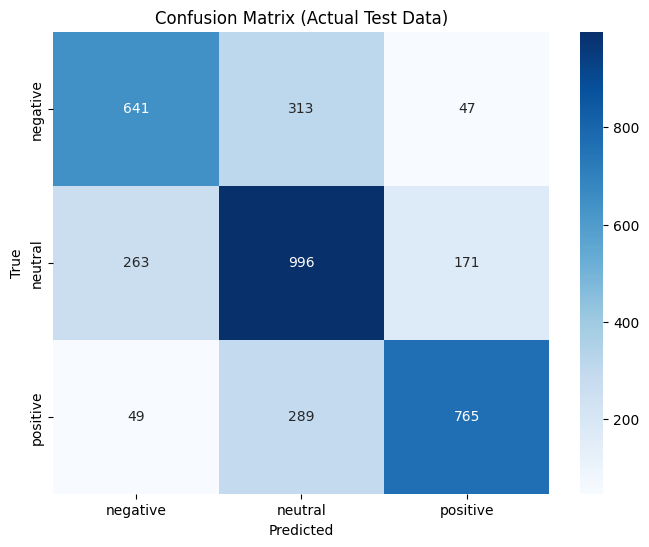

In [23]:
# prompt: extract y_test_actual from test['sentiment'] and one hot encoding and calculate accuracy and output confusion matrix

import matplotlib.pyplot as plt
import numpy as np
# Extract the actual sentiment labels from the test set
y_test_actual = test['sentiment']

# Encode the actual sentiment labels using the same LabelEncoder used for training
y_test_actual_encoded = label_encoder.transform(y_test_actual)

# Convert the actual sentiment labels to one-hot encoding
y_test_actual_one_hot = tf.keras.utils.to_categorical(y_test_actual_encoded)

# Evaluate the model on the actual test data
loss_actual, accuracy_actual = model.evaluate(X_test_actual, y_test_actual_one_hot)

print("Actual Test Loss:", loss_actual)
print("Actual Test Accuracy:", accuracy_actual)

# Get predicted labels for the actual test data
y_test_actual_pred_labels = np.argmax(test_pred_probs, axis=1)
y_test_actual_true_labels = np.argmax(y_test_actual_one_hot, axis=1)

# Calculate and print the confusion matrix for the actual test data
conf_matrix_actual = confusion_matrix(y_test_actual_true_labels, y_test_actual_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_actual, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, # Use actual class labels
            yticklabels=label_encoder.classes_) # Use actual class labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Actual Test Data)')
plt.show()